In [2]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import matplotlib.colors as colors
from sklearn.cluster import MeanShift
from itertools import cycle

In [2]:
c =0.299792458
n =1.3195
v=c/n 
print v

0.227201559682


In [3]:
info = pickle.load(open("./double_pulse/DP_Tau1PeV_Big.pkl", "rb"))
data = np.load("./double_pulse/DP_Tau1PeV_Big_data.npy")
print len(info), len(data)

216 216


In [4]:
for event in data:
    for i in event:
        if i[4] < 0:
            i[4] = 0

In [5]:
D = data[57]
I = info[57]
print len(D), len(I)

168704 11


In [6]:
for i,e in enumerate(info):
    print i, e["id"],"E_nu={0:2.2e} E_tau={1:2.2e} Qtot={2:.2f}".format(e['nu_energy'], e['tau_energy'], e['qtotal'])

0 (76, 4294967295, 631, 0) E_nu=1.43e+06 E_tau=1.06e+06 Qtot=120.10
1 (86, 4294967295, 261, 0) E_nu=1.32e+06 E_tau=1.16e+06 Qtot=23433.80
2 (72, 4294967295, 409, 0) E_nu=1.07e+06 E_tau=1.03e+06 Qtot=74635.15
3 (72, 4294967295, 436, 0) E_nu=1.17e+06 E_tau=1.07e+06 Qtot=82397.20
4 (72, 4294967295, 737, 0) E_nu=1.05e+06 E_tau=1.02e+06 Qtot=33997.90
5 (30, 4294967295, 99, 0) E_nu=1.53e+06 E_tau=1.00e+06 Qtot=1325.27
6 (30, 4294967295, 189, 0) E_nu=1.00e+06 E_tau=1.00e+06 Qtot=98646.33
7 (30, 4294967295, 277, 0) E_nu=1.55e+06 E_tau=1.16e+06 Qtot=3747.80
8 (30, 4294967295, 533, 0) E_nu=1.35e+06 E_tau=1.10e+06 Qtot=1894.08
9 (19, 4294967295, 133, 0) E_nu=1.07e+06 E_tau=1.07e+06 Qtot=65422.35
10 (19, 4294967295, 314, 0) E_nu=2.21e+06 E_tau=1.08e+06 Qtot=10390.80
11 (28, 4294967295, 340, 0) E_nu=1.15e+06 E_tau=1.11e+06 Qtot=635.07
12 (28, 4294967295, 630, 0) E_nu=1.02e+06 E_tau=1.01e+06 Qtot=645.77
13 (28, 4294967295, 634, 0) E_nu=1.52e+06 E_tau=1.19e+06 Qtot=3869.20
14 (98, 4294967295, 569, 0)

In [7]:
def make_plots(labels, data, truth):
   
    mask_b1 = labels==0
    mask_b2 = labels==1
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.scatter(data[mask_b1][:,3],data[mask_b1][:,2],s=data[mask_b1][:,4],c='r',alpha =0.05,marker='.')
    ax.scatter(data[mask_b2][:,3],data[mask_b2][:,2],s=data[mask_b2][:,4],c='b',alpha =0.05,marker='.')
    ax.scatter(truth[:,3],truth[:,2], s=truth[:,4], c='g', marker='.')
    
    plt.show()

In [8]:
def make_waveforms(labels,data,info):
    print labels.shape, data.shape, len(info)
    qdoms = -np.unique(-data[:,9])[:30]
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    for i, q in enumerate(qdoms):
        mask = data[:,9]==q 
        wf_data = data[mask]
        if len(wf_data) != 128:
            print wf_data[:,5]
            print wf_data[:,6]
        wf_labels = labels[mask]
        wf_data[wf_data[:, 3].argsort()]
        max_wf = np.max(wf_data[:,4])
        ax = fig.add_subplot(10, 3, i+1)
        ax.text(wf_data[0][3], max_wf*1.0, "{0},{1}, E{2:2.2e}GeV, Q{3:.1f}PE, q{4:.1f}PE".format(wf_data[0][7],wf_data[0][8],info["tau_energy"],info["qtotal"],q), color="k",fontsize = 16 )     
        ax.set_ylim(0,max_wf*1.2)
        
        mask_b1 = wf_labels==0
        mask_b2 = wf_labels==1
        
        ax.plot(wf_data[mask_b1][:,3],wf_data[mask_b1][:,4],'r', label = "ONE")
        ax.plot(wf_data[mask_b2][:,3],wf_data[mask_b2][:,4],'b', label = "TWO")
            
    fig.tight_layout()
    #name_0 = name+"_{0}.png".format(data.index(i))
    #plt.savefig(name_0)
    plt.show()
    #plt.close('all')

In [9]:
GooD = []
for d in D:
    #if (d[6] != 0) and (d[6] != 0):
    #    print d[5], d[6]
    if d[6] == 0:
        GooD.append(d)
GooD = np.vstack(GooD)
print GooD.shape

(130560, 10)


In [10]:
def bang2_pos_calculate(one, one_dir, length):
    if length > 0:
        l_x = np.sin(one_dir[0])*np.cos(one_dir[1])*length
        l_y = np.sin(one_dir[0])*np.sin(one_dir[1])*length
        l_z = np.cos(one_dir[0])*length
    two = [0,0,0]
    two[0] = one[0]-l_x 
    two[1] = one[1]-l_y 
    two[2] = one[2]-l_z 
    
    return two

In [11]:
true_bangs = []
for e in info:
    b1 = e['tau_position']+(e['tau_time'][0]*v,1000) 
    b2_pos = bang2_pos_calculate(e['tau_position'],e["tau_direction"],e["tau_length"])
    b2 = b2_pos +[e['tau_time'][1]*v,1000]
    
    true_bangs.append(np.stack((b1,b2)))
print true_bangs[57].shape

(2, 5)


In [12]:
#select the HighCharge String
sts = -np.unique(-GooD[:,7])
st_charge = []

for st in sts:
    st_charge.append((st, sum(GooD[GooD[:,7]==st][:,9])))

st_charge = np.array(st_charge)
st_charge = st_charge[st_charge[:, 1].argsort()][::-1][0]

In [13]:
print st_charge

[  5.50000000e+01   4.02532800e+06]


In [14]:
mask = GooD[:,7]==st_charge[0]
string_data = GooD[mask]
print string_data.shape

(3072, 10)


In [15]:
BRCH = Birch(n_clusters=2).fit(string_data[:,2:4],string_data[:,4])
labels_BRCH = BRCH.predict(string_data[:,2:4])

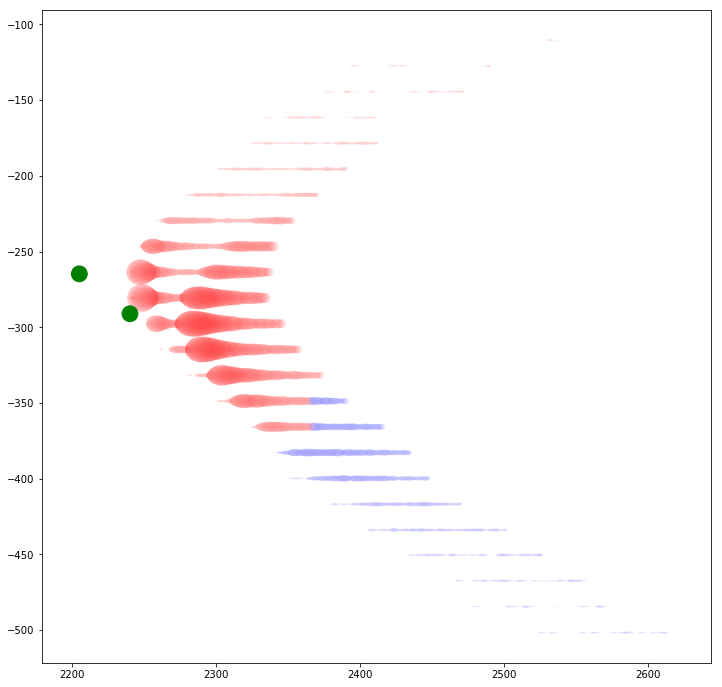

In [16]:
make_plots(labels_BRCH,string_data,true_bangs[57])

(3072,) (3072, 10) 11


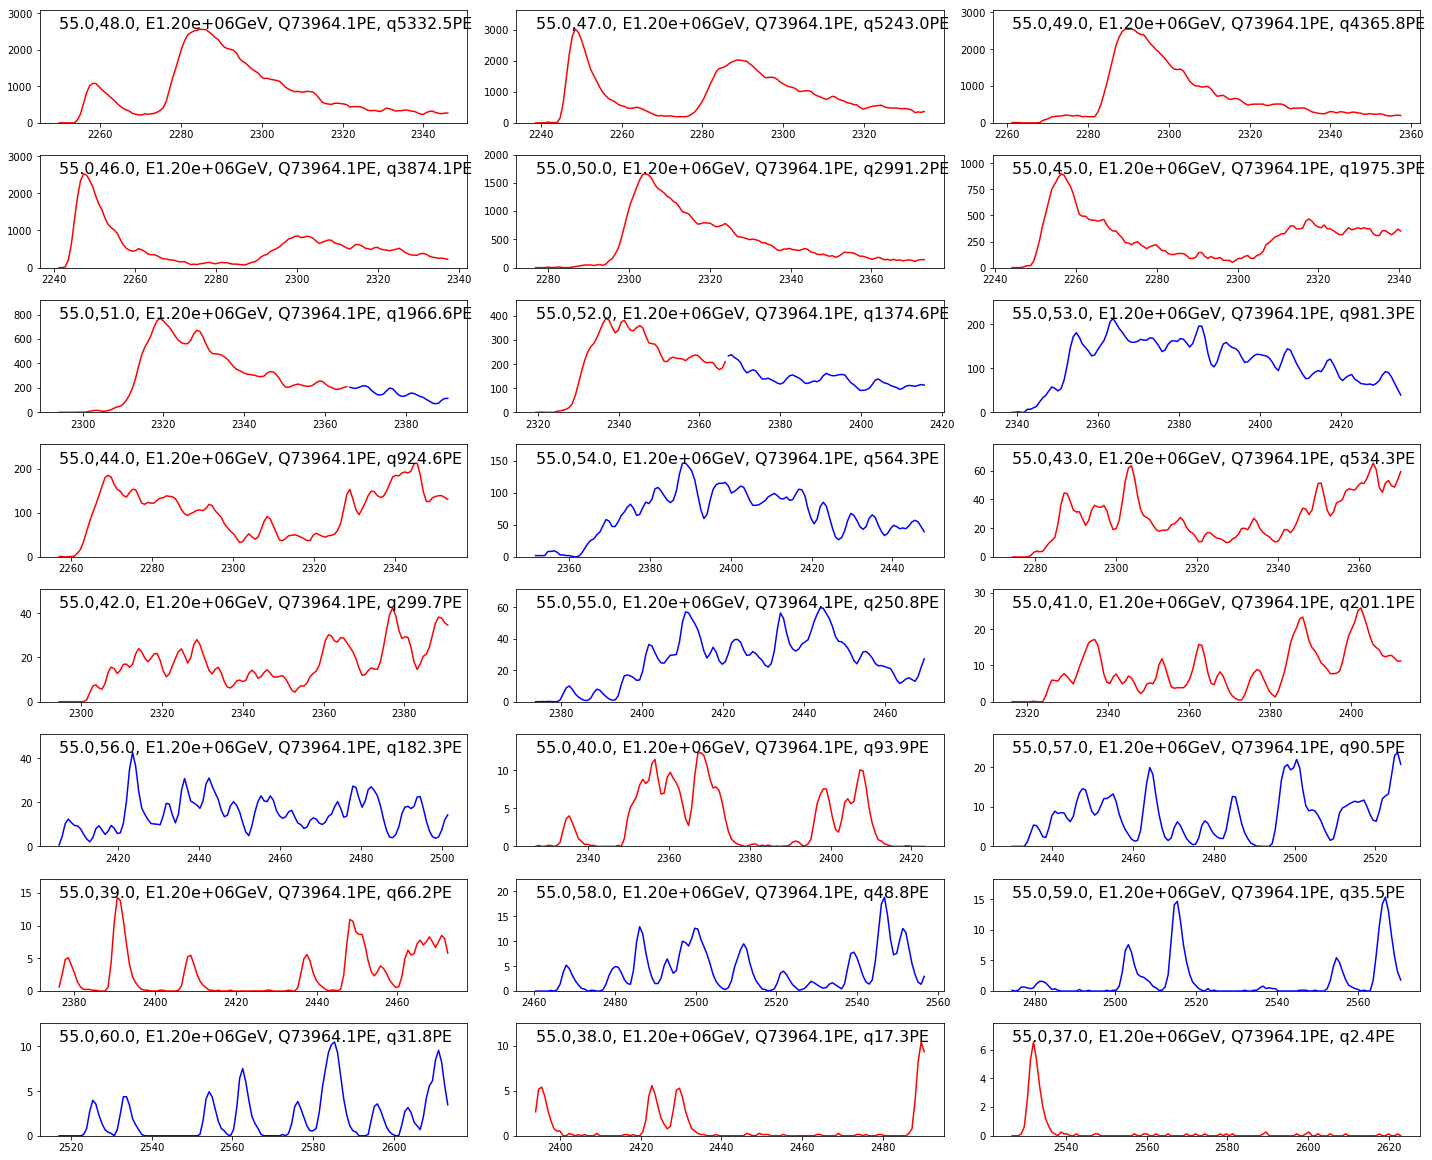

In [17]:
make_waveforms(labels_BRCH,string_data,I)

In [25]:
DBS = DBSCAN(eps=18).fit(string_data[:,2:4],string_data[:,4])
labels_DBS = DBS.labels_
uni, count = np.unique(labels_DBS, return_counts =True)
print (dict(zip(uni,count)))

{0: 128, 1: 2944}


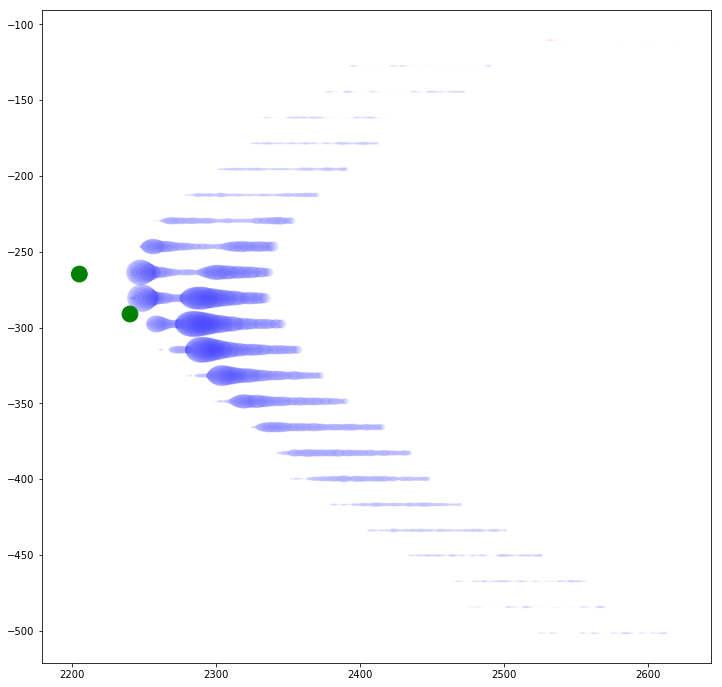

In [19]:
make_plots(labels_DBS,string_data,true_bangs[57])

In [26]:
GM_data = []
for sample in string_data:
    if not sample[4]<0: 
        for j in range(0,int(sample[4])):
            GM_data.append(sample)
GM_data = np.vstack(GM_data)

In [28]:
GM = GaussianMixture(n_components=2).fit(string_data[:,2:4])
labels_GM = GM.predict(string_data[:,2:4])
unique, counts = np.unique(labels_GM, return_counts=True)
print dict(zip(unique, counts))

{0: 1280, 1: 1792}


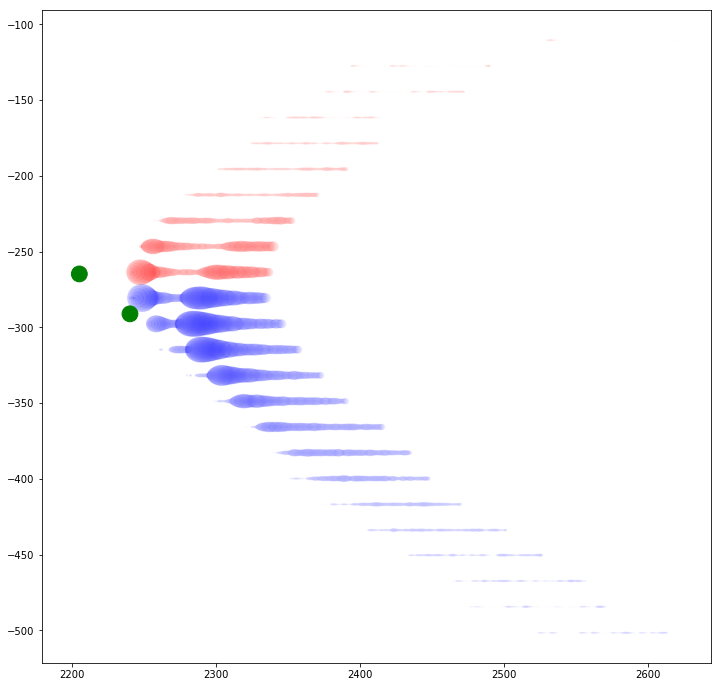

In [29]:
make_plots(labels_GM,string_data,true_bangs[57])

(3072,) (3072, 10) 11


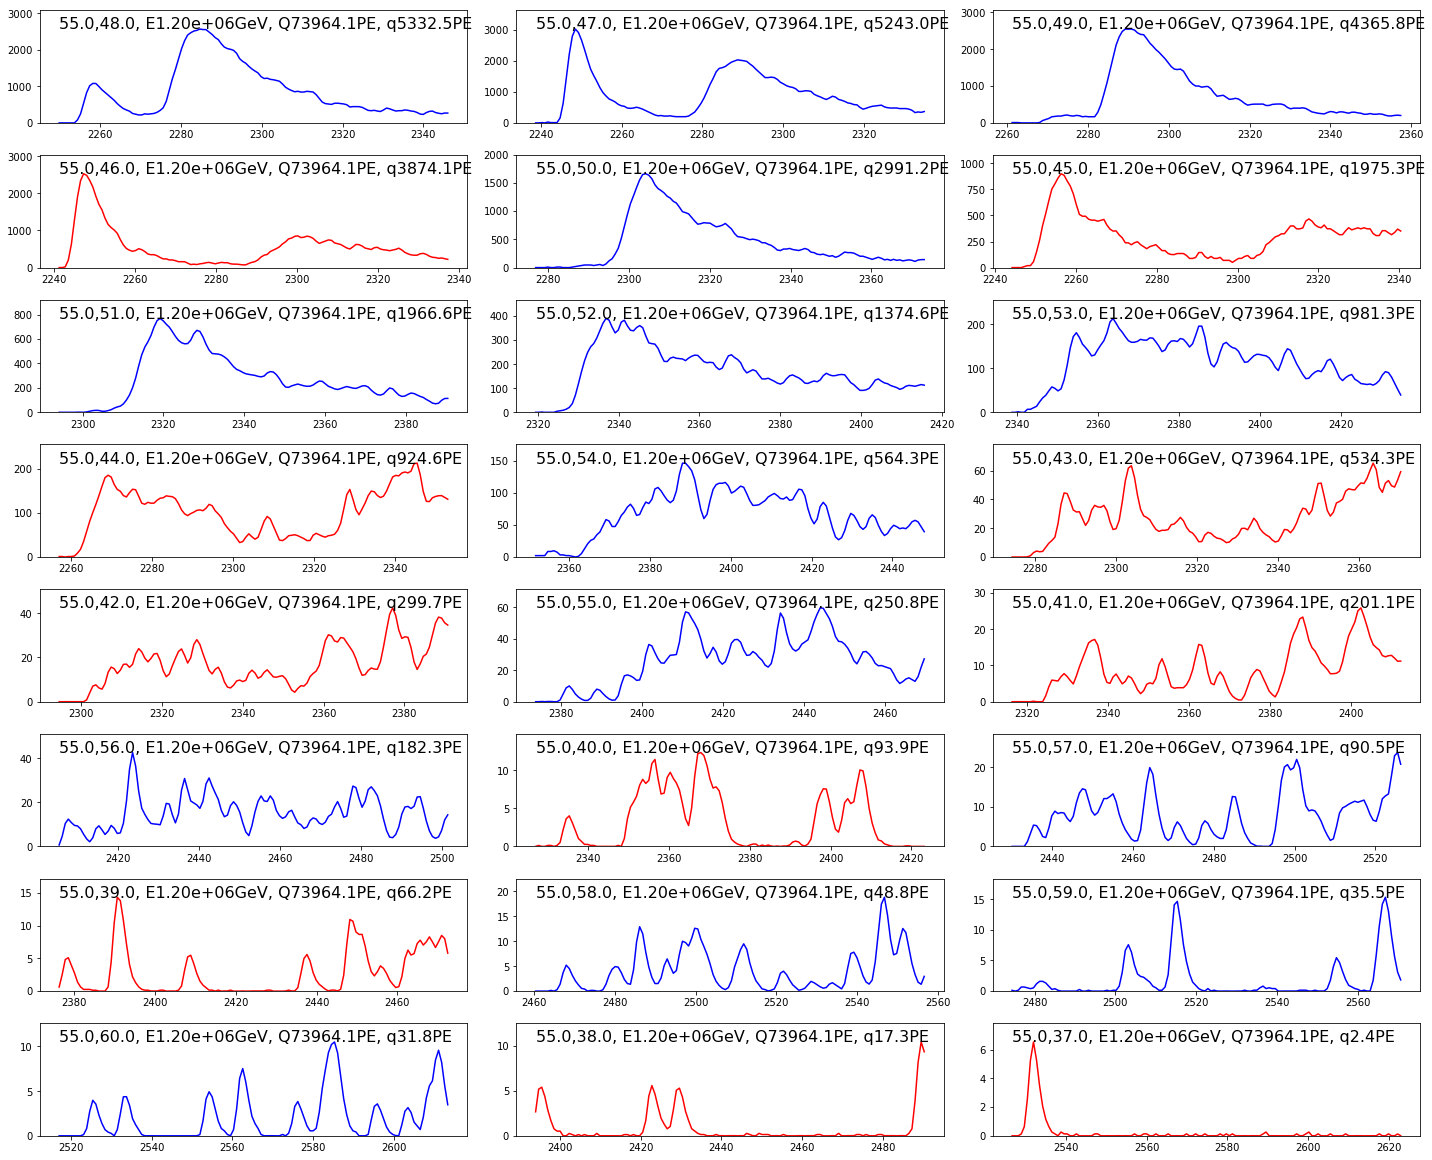

In [30]:
make_waveforms(labels_GM,string_data,I)

In [31]:
GM2 = GaussianMixture(n_components=2).fit(GM_data[:,2:4])
labels_GM2 = GM.predict(string_data[:,2:4])
unique, counts = np.unique(labels_GM2, return_counts=True)
print dict(zip(unique, counts))

{0: 1280, 1: 1792}


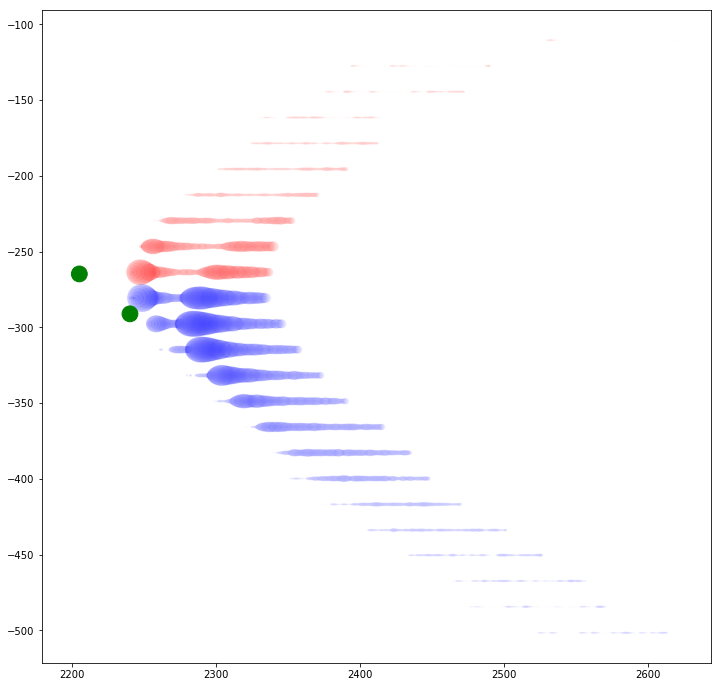

In [32]:
make_plots(labels_GM2,string_data,true_bangs[57])

(3072,) (3072, 10) 11


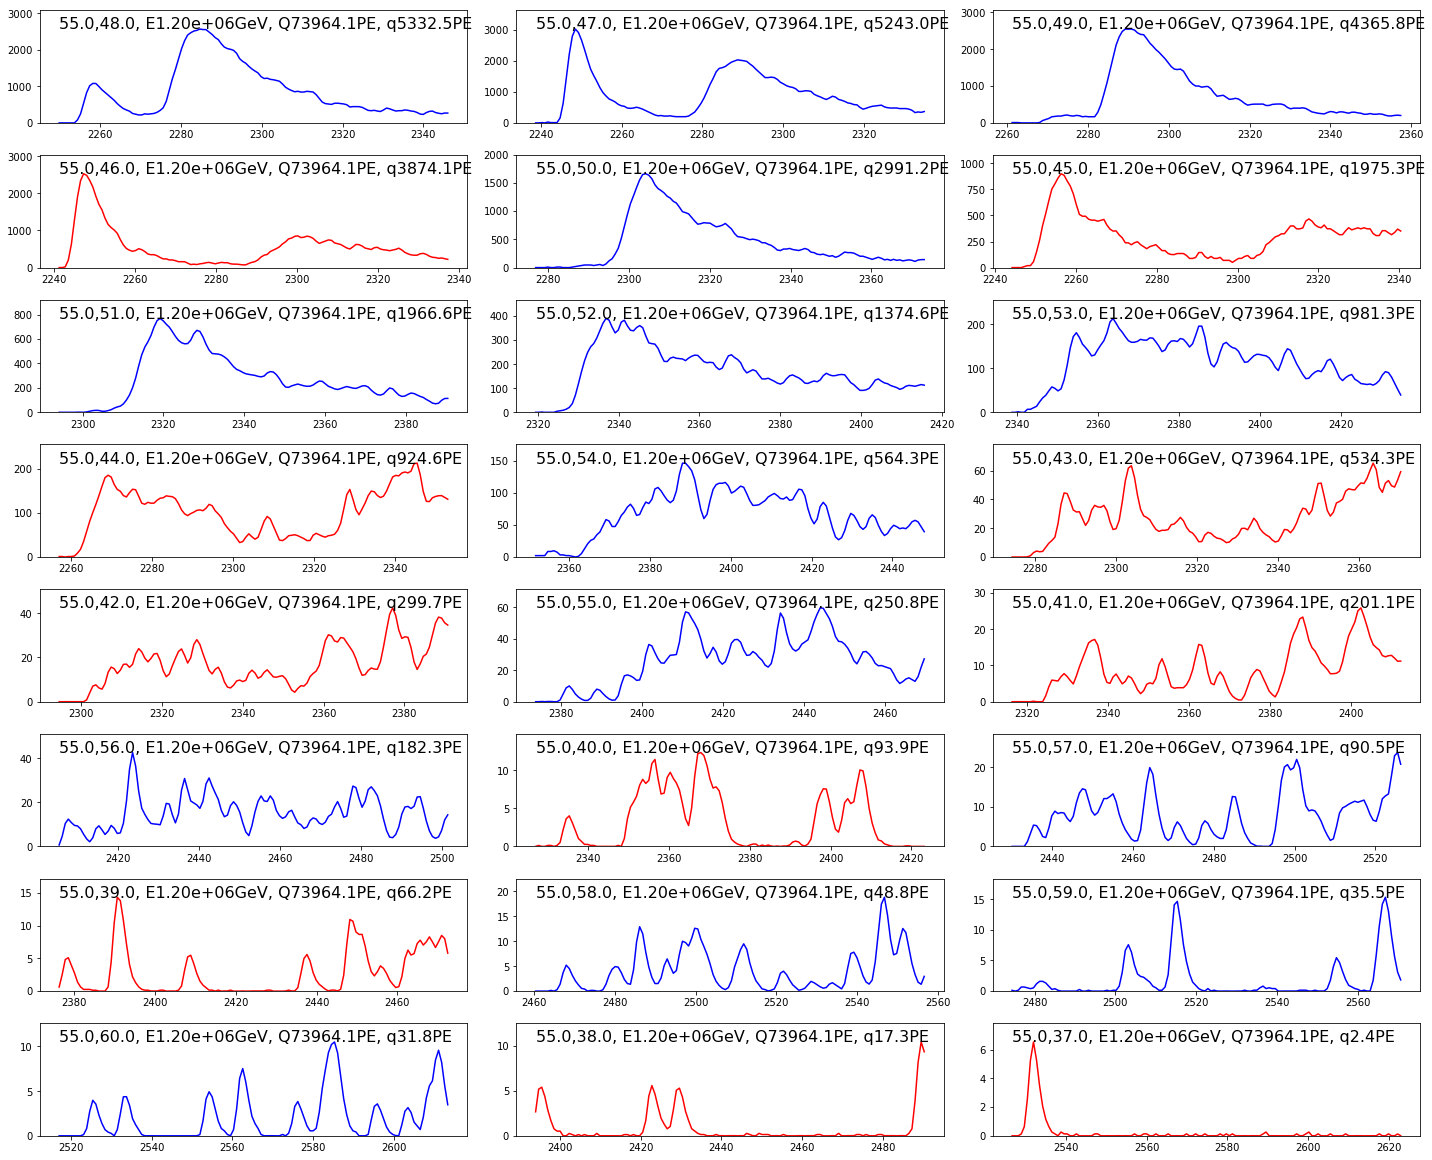

In [33]:
make_waveforms(labels_GM2,string_data,I)

In [34]:
AG = AgglomerativeClustering(n_clusters=2, linkage = 'ward').fit(string_data[:,2:4])
labels_AG = AG.labels_
unique, counts = np.unique(labels_AG, return_counts=True)
print dict(zip(unique, counts))

{0: 2387, 1: 685}


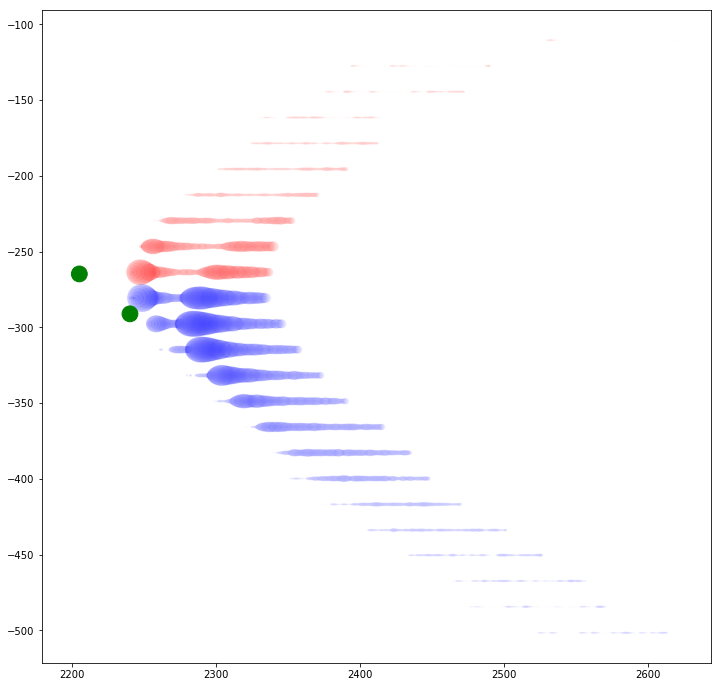

In [35]:
make_plots(labels_GM,string_data,true_bangs[57])

(3072,) (3072, 10) 11


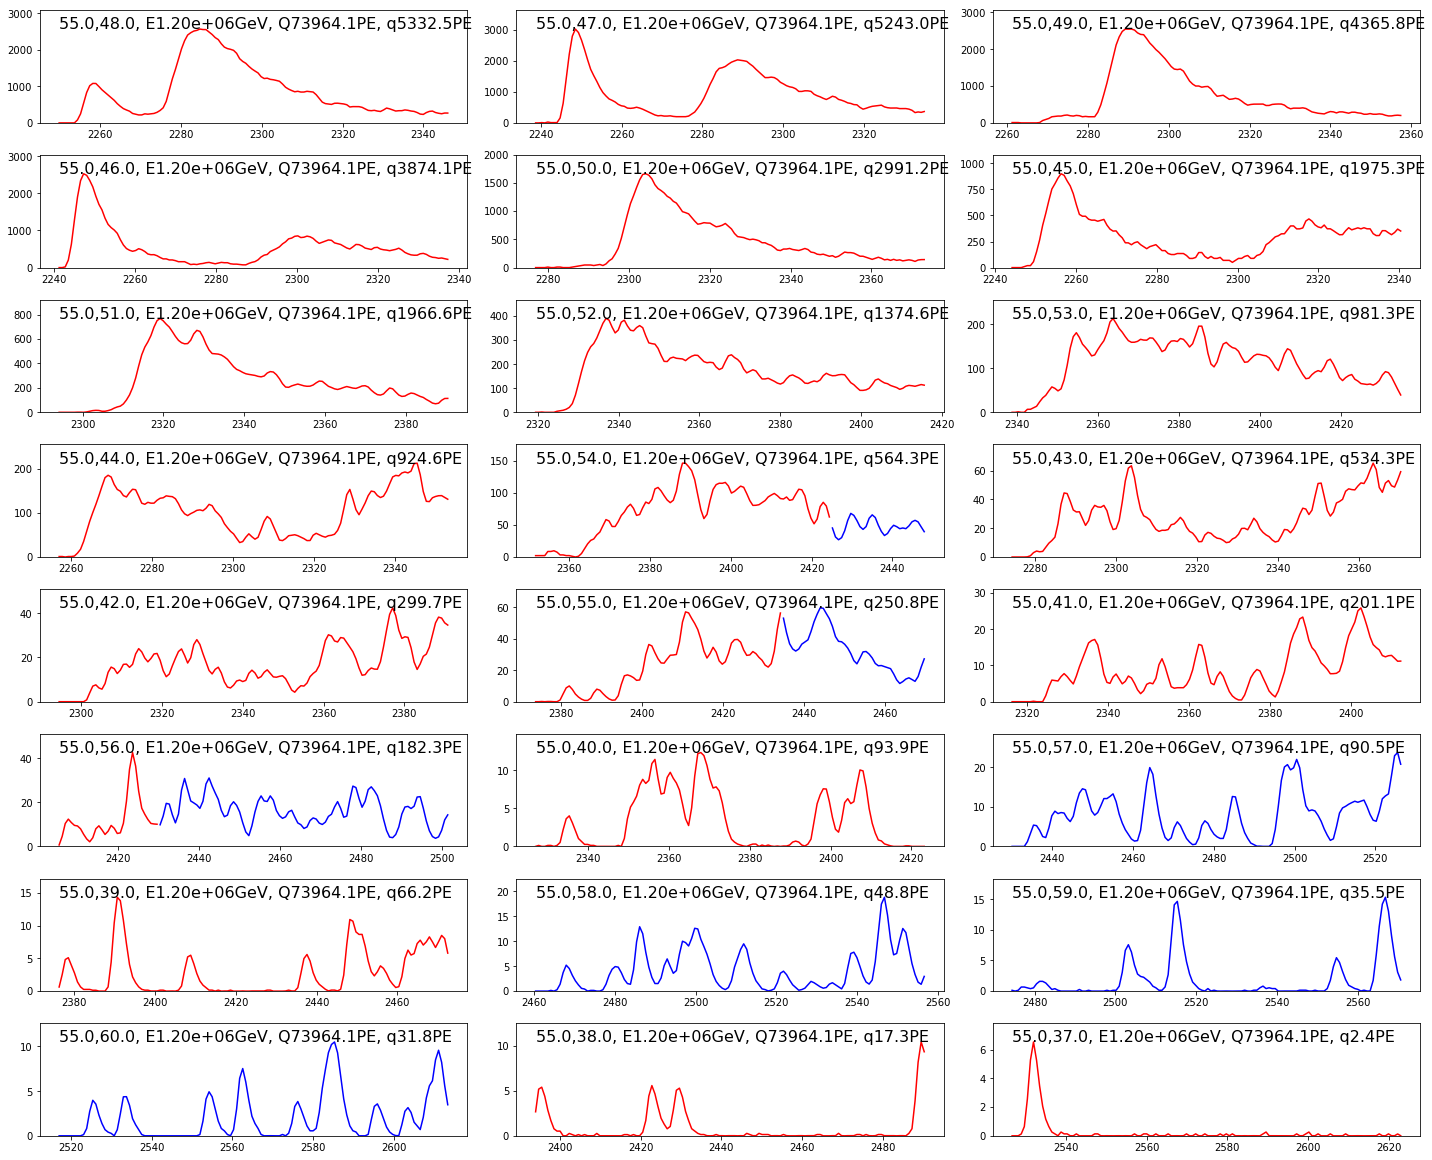

In [36]:
make_waveforms(labels_AG,string_data,I)

In [37]:
KM = KMeans(n_clusters=2).fit(string_data[:,2:4],string_data[:,4])
labels_KM = KM.predict(string_data[:,2:4])
unique, counts = np.unique(labels_KM, return_counts=True)
print dict(zip(unique, counts))

{0: 1917, 1: 1155}


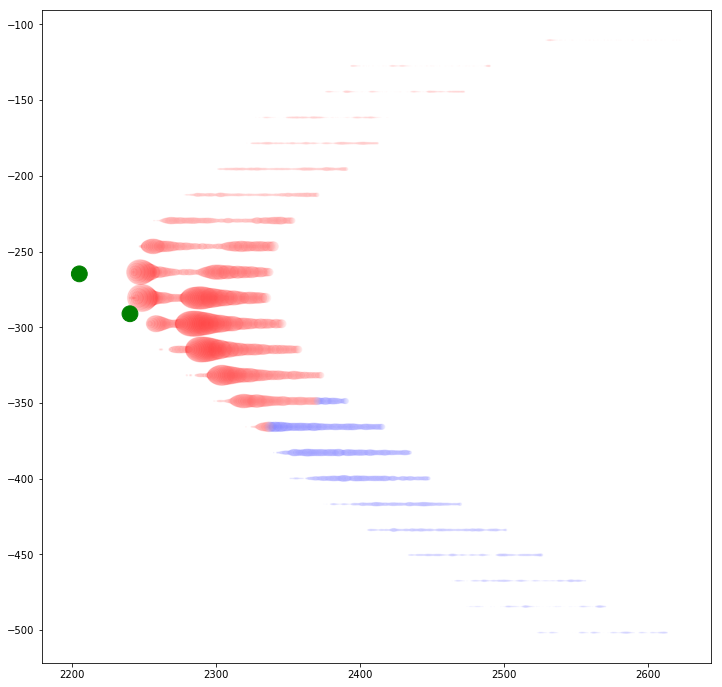

In [38]:
make_plots(labels_KM,string_data,true_bangs[57])

(3072,) (3072, 10) 11


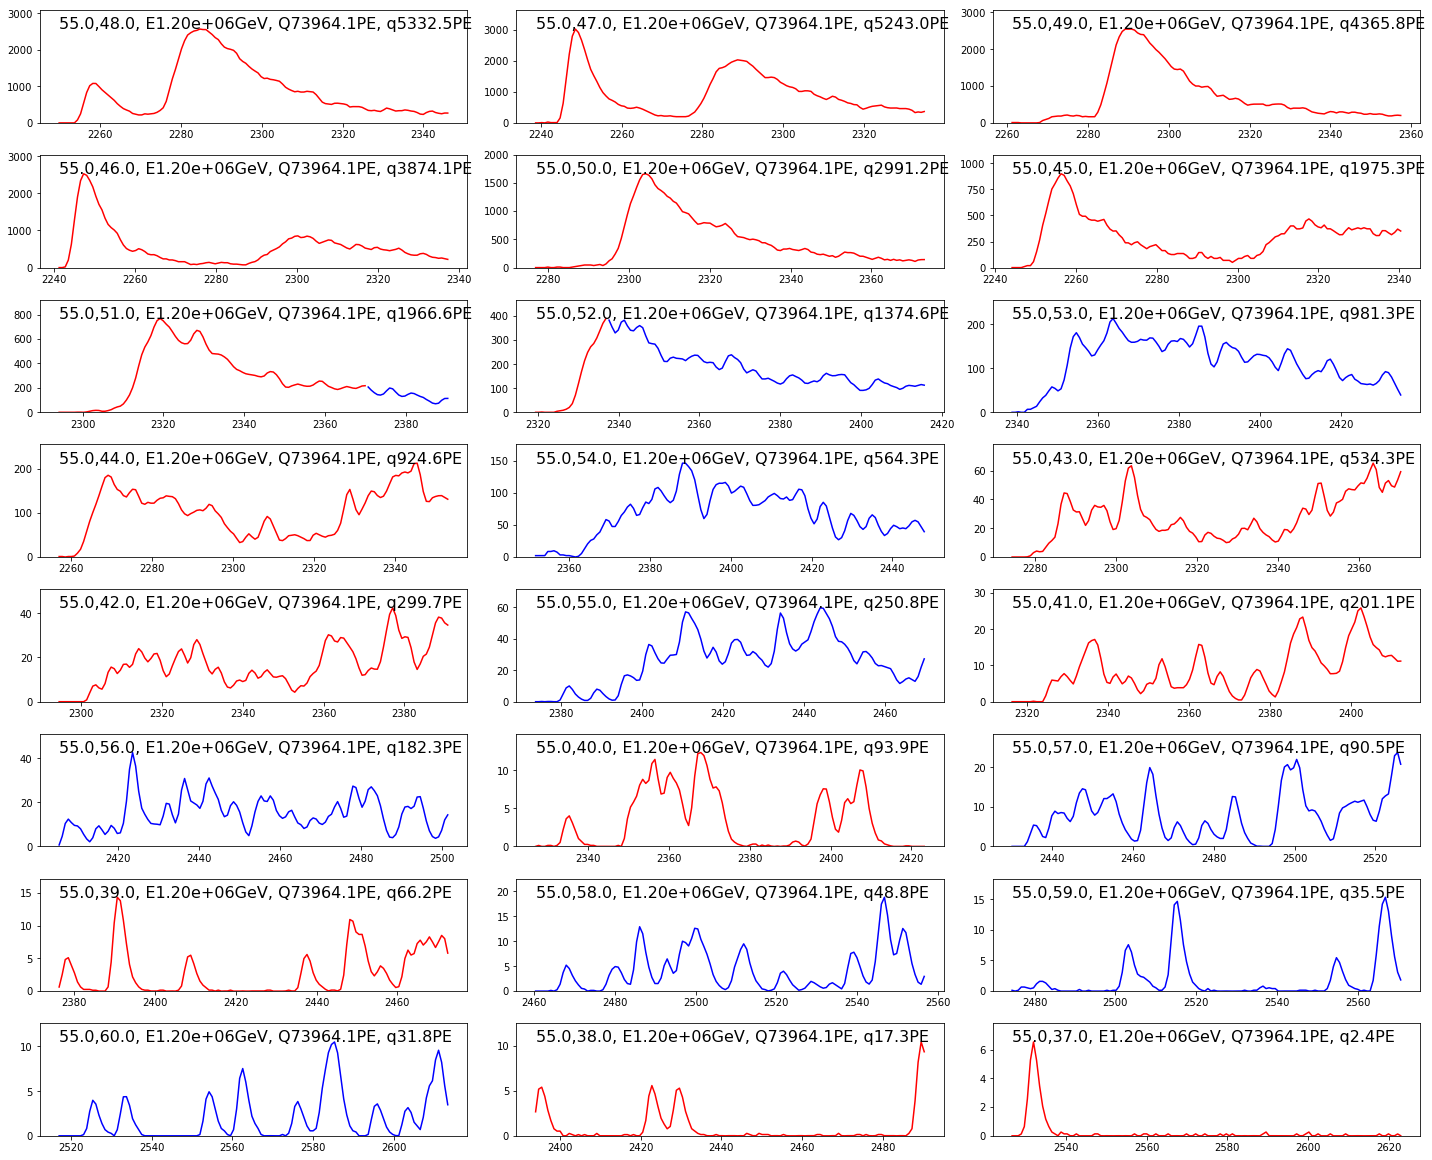

In [39]:
make_waveforms(labels_KM,string_data,I)